In [17]:
from sklearn.metrics import mutual_info_score
from collections import deque
from adjustText import adjust_text

import matplotlib.pyplot as plt
import pandas as pd
import koreanize_matplotlib
import seaborn as sns
import numpy as np
import scipy.stats as stats
import mysql.connector

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 한글 폰트 사용을 위해서 세팅
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import font_manager, rc

font_path = "/usr/share/fonts/NanumFont/NanumGothic.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

import configparser

from plt_custom_def import make_gen_dict, make_pie, show_label

In [2]:
# DB 접속

config = configparser.ConfigParser()
config.read('../config.ini')
dev = config['dev']

remote = mysql.connector.connect(
    host = dev['host'],
    port = dev['port'],
    user = dev['user'],
    password = dev['password'],
    database = dev['database']
)

mycursor = remote.cursor(buffered=True)

### 1. 혼합배출 비율이 높은 지역의 가구구성을 파이차트로 그려보자
- 대상지역: 경북, 충남

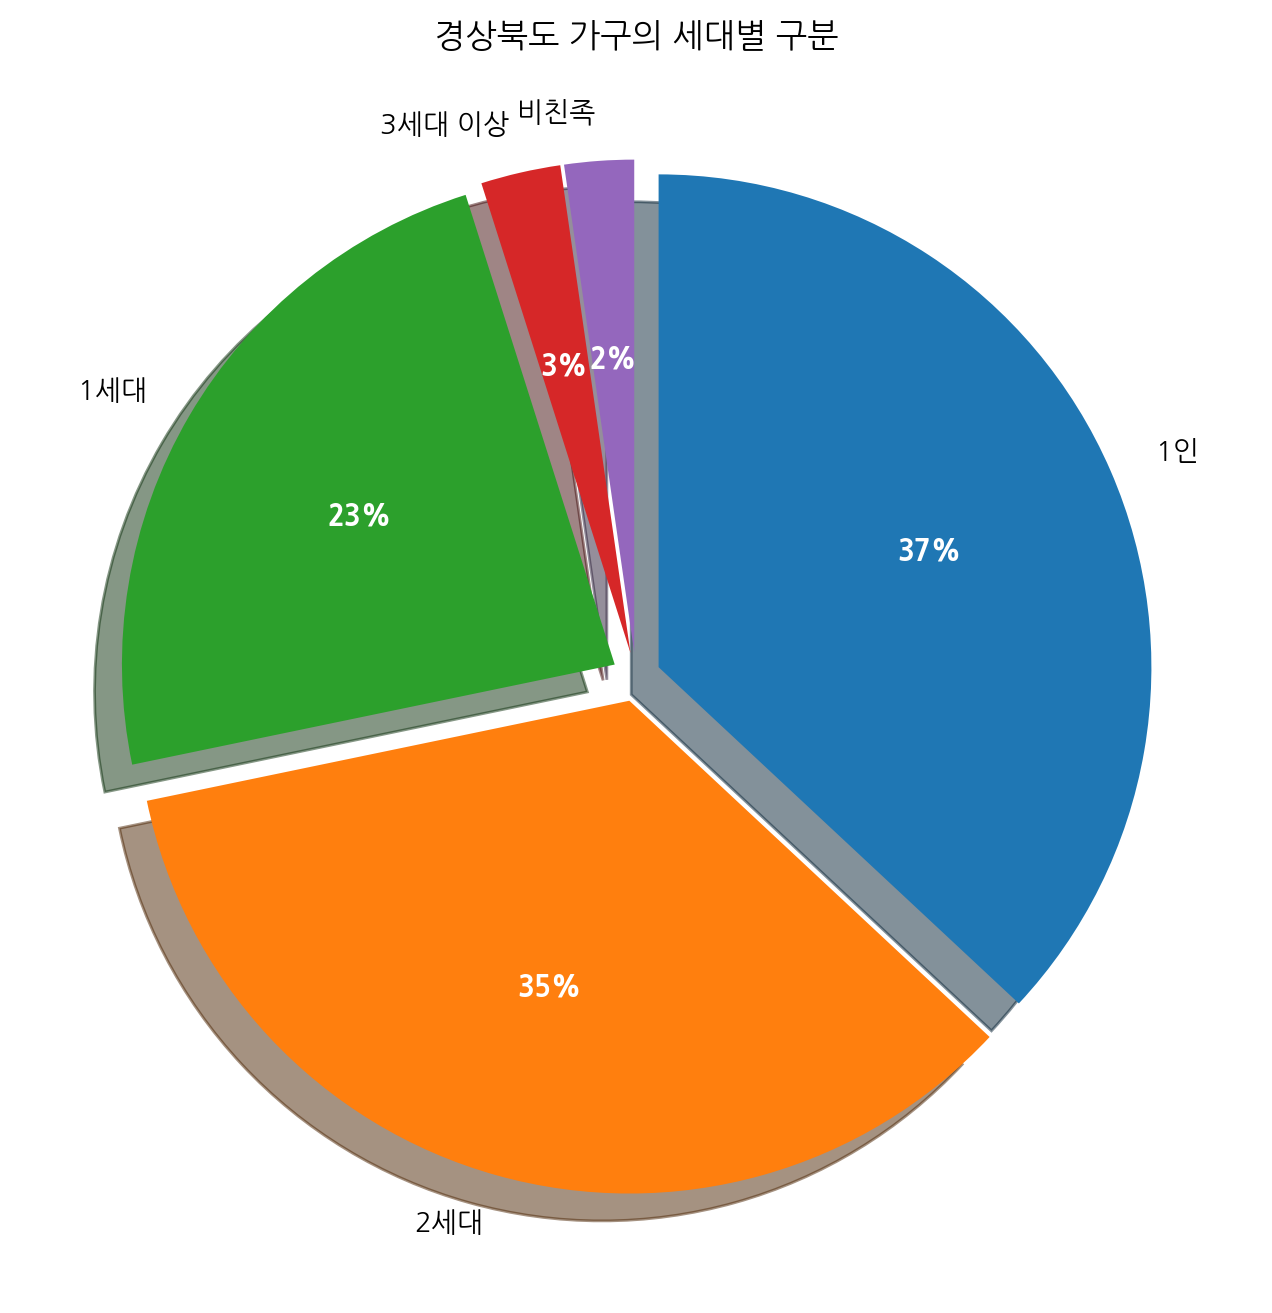

In [6]:
sql = "select * from home_generation where region_name = '경상북도'"
mycursor.execute(sql)
result = mycursor.fetchone()

gen_dict = make_gen_dict(result)
make_pie(gen_dict, '경상북도 가구의 세대별 구분')

- 예상 외로 1인 가구가 37퍼센트로 가장 많다.

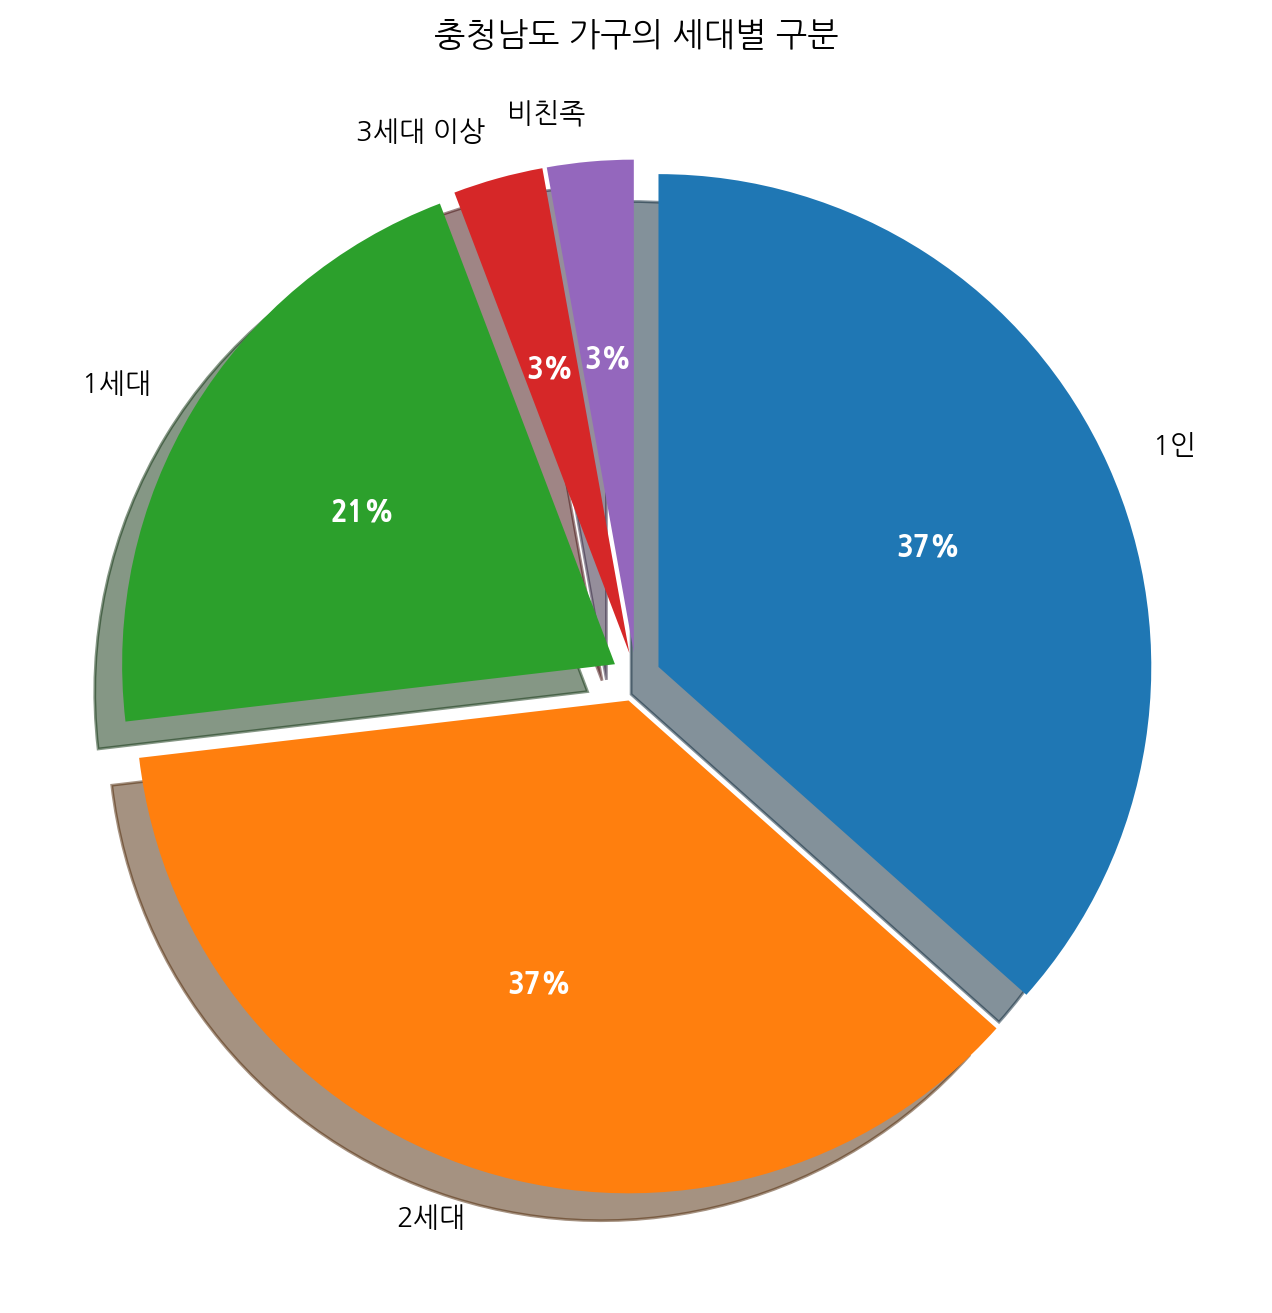

In [5]:
sql = "select * from home_generation where region_name = '충청남도'"
mycursor.execute(sql)
result = mycursor.fetchone()

gen_dict = make_gen_dict(result)

make_pie(gen_dict, '충청남도 가구의 세대별 구분')

### 2. 혼합배출 비율이 낮은 지역의 가구구성을 파이차트로 그려보자
- 대상 지역: 제주, 서울

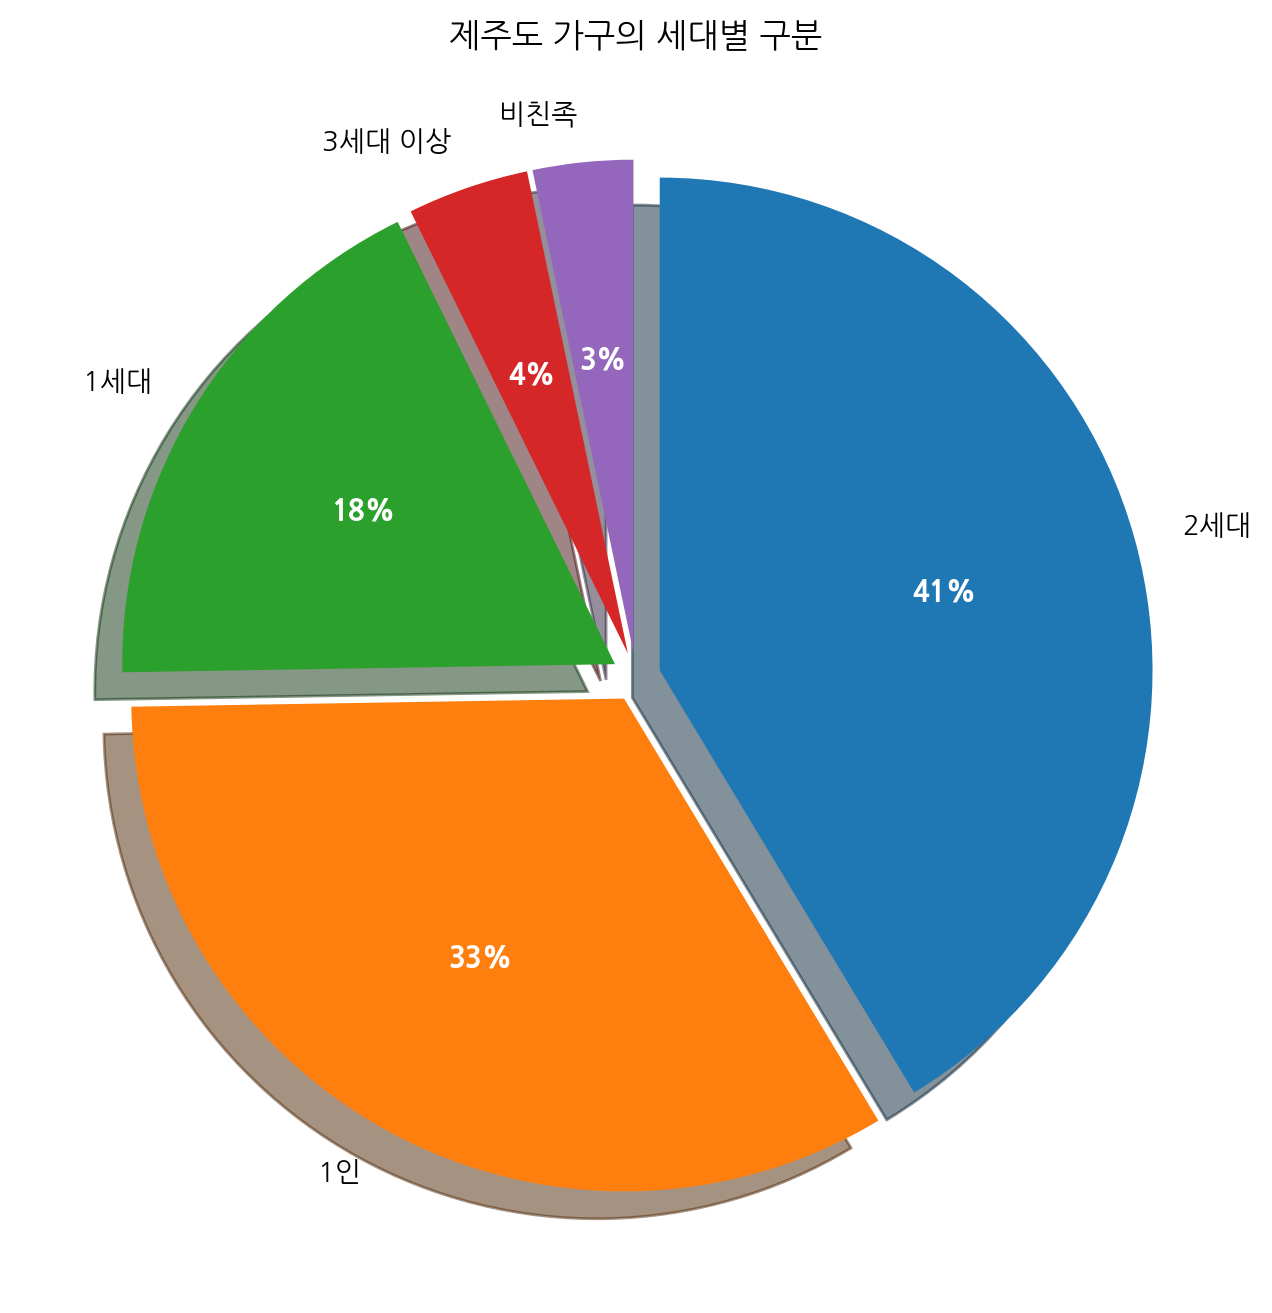

In [7]:
# 혼합배출 비율이 가장 낮은 제주도는?
sql = "select * from home_generation where region_name like '%제주%'"
mycursor.execute(sql)
result = mycursor.fetchone()

gen_dict = make_gen_dict(result)

make_pie(gen_dict, '제주도 가구의 세대별 구분')

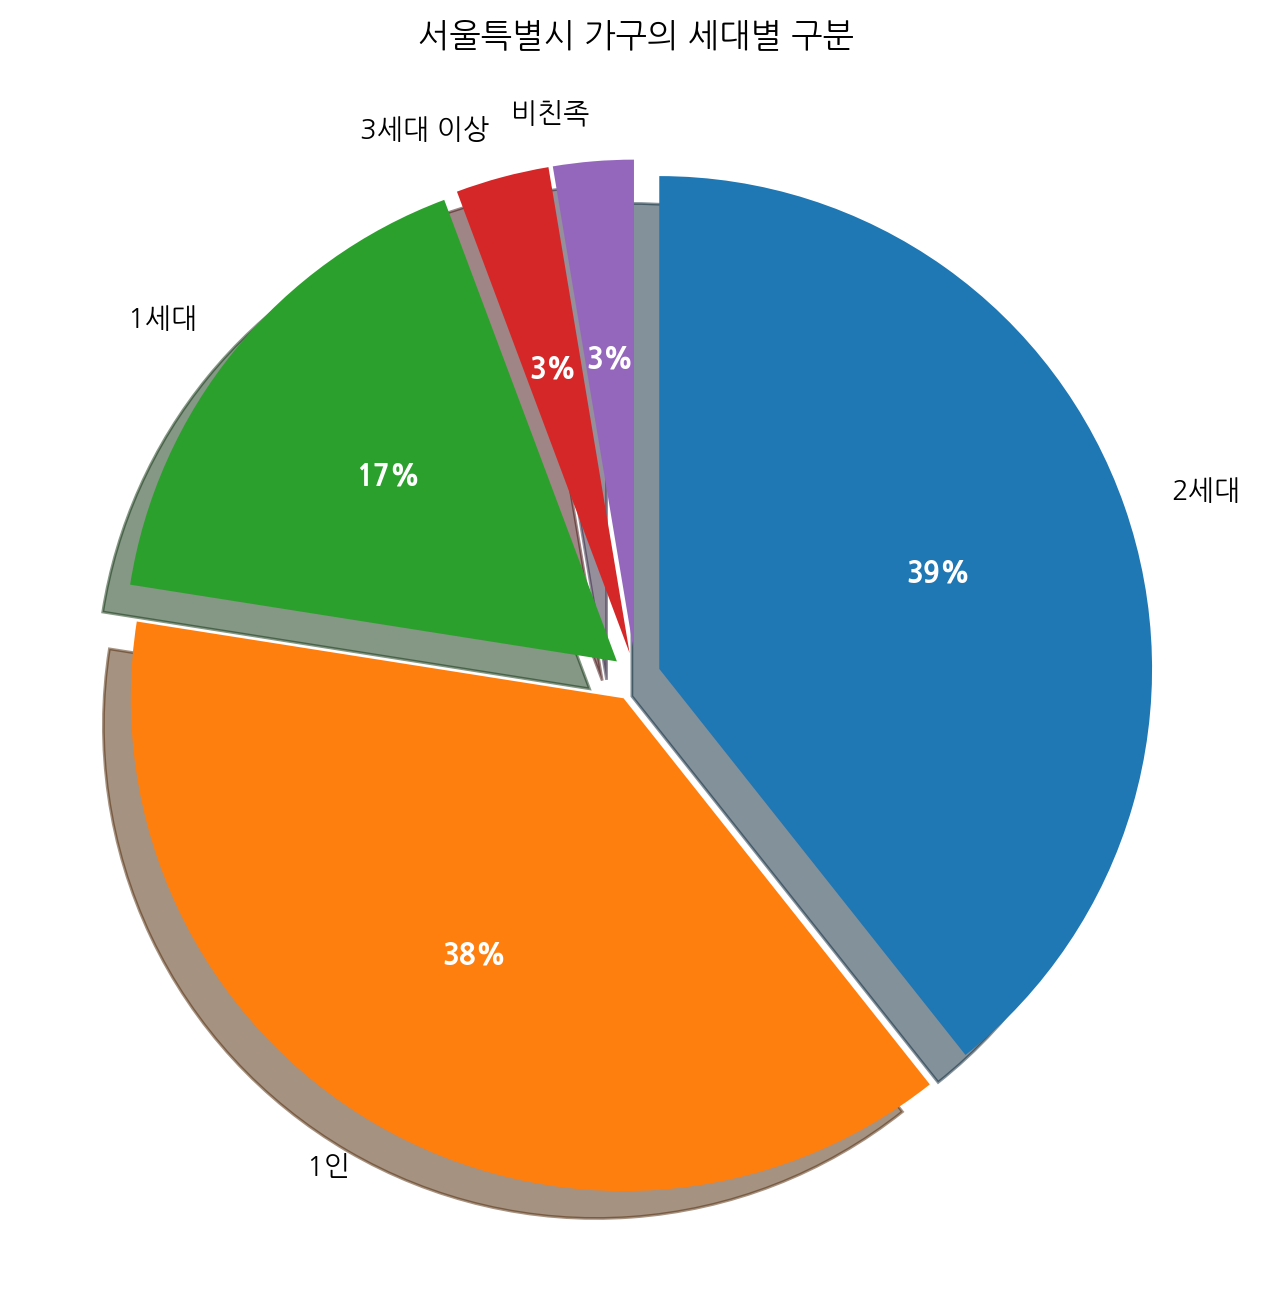

In [8]:
# 서울
sql = "select * from home_generation where region_name like '%서울%'"
mycursor.execute(sql)
result = mycursor.fetchone() # 전체 가구 : 1세대, 2세대, 3세대, 4세대, 1인, 비친족

gen_dict = make_gen_dict(result)

make_pie(gen_dict, '서울특별시 가구의 세대별 구분')

- 혼합배출 비율이 (2022년 기준) 전국 최저인 제주에서는 2세대 비율이 1위, 1인 가구 비율은 조금 낮다.
- 1인 가구 비율이 높으면(그리고 아마도 고령 1인 가구 비율이 높으면), 혼합배출을 더 많이 할까?

#### Q1. 1인 가구/연령대와 혼합배출 비율은 상관있을까?

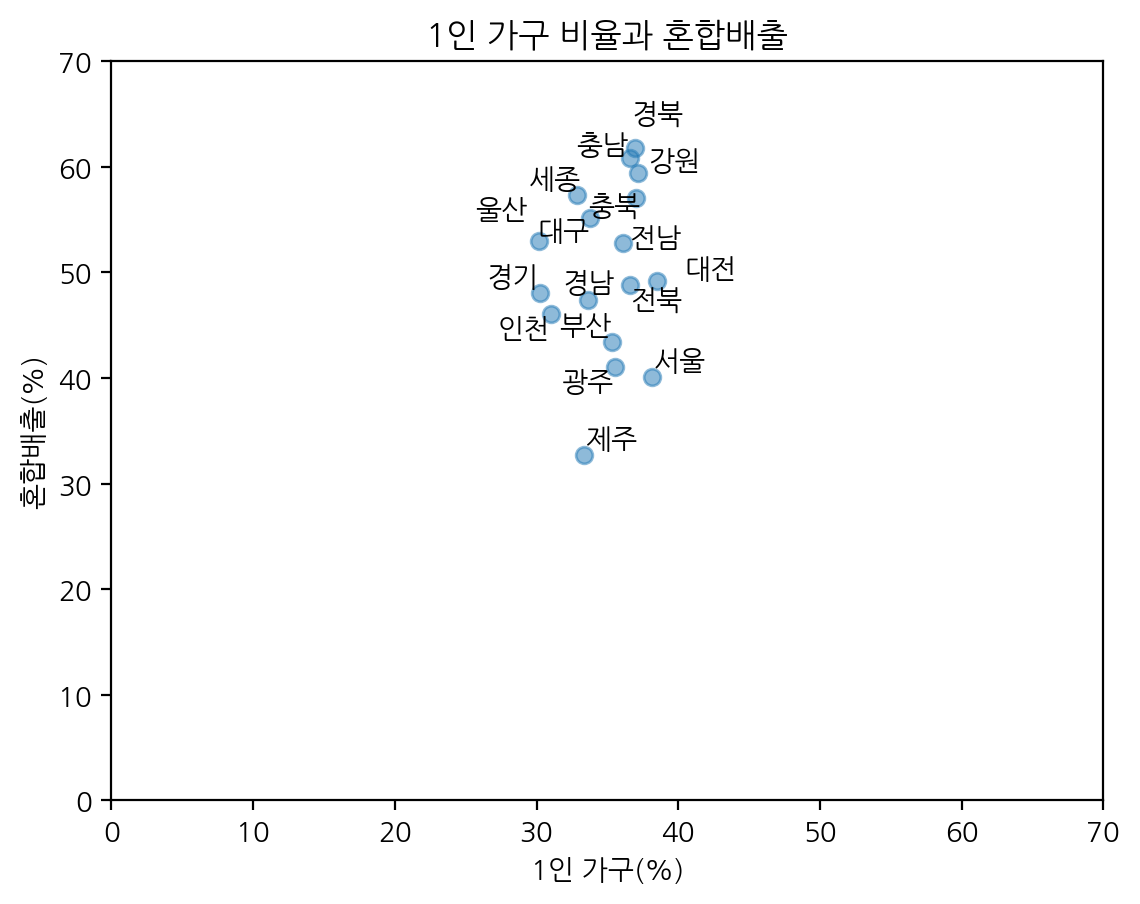

In [4]:
# 1인 가구 비율
sql = open("02.select_single_rate_and_trash.sql", encoding="UTF-8").read()  # 윈도우에서 사용하는 코덱이 CP949라 에러발생하여 인코딩 옵션 추가
mycursor.execute(sql)
result = mycursor.fetchall()

region_list = []
single_rate_list = []
mix_rate_list = []

for v in result:
    region_list.append(v[0])
    single_rate_list.append(v[1])
    mix_rate_list.append(v[2])

plt.xlim(0, 70)
plt.ylim(0, 70)
plt.scatter(single_rate_list, mix_rate_list, alpha=0.5)
texts = show_label(region_list, single_rate_list, mix_rate_list, 0, 0, 'center')
adjust_text(texts)
plt.title('1인 가구 비율과 혼합배출')
plt.xlabel('1인 가구(%)')
plt.ylabel('혼합배출(%)')
plt.show();

In [10]:
# 공분산 구하기
np.cov(np.array(single_rate_list, dtype=float), 
       np.array(mix_rate_list, dtype=float))[0,1]  # 1인가구일 때 혼합배출을 더 하는 편

3.4524961762858215

In [11]:
stats.pearsonr(np.array(single_rate_list, dtype=float), 
               np.array(mix_rate_list, dtype=float))
# 상관계수 0.16
# p-value 0.53 : 상관관계 없을 확률 50%

PearsonRResult(statistic=0.16081401420826588, pvalue=0.5375098629860269)

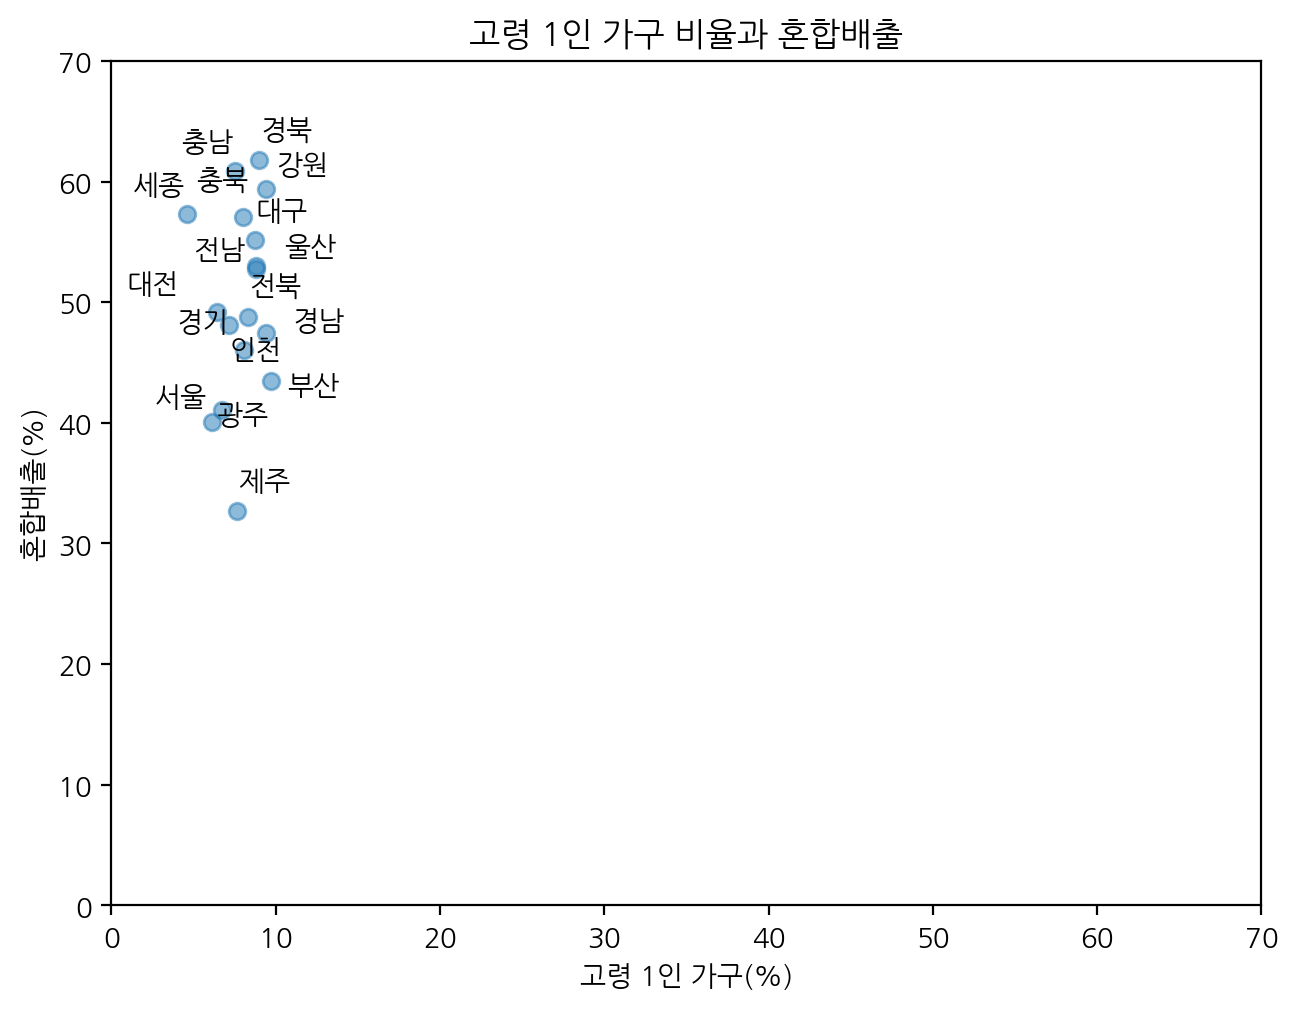

In [5]:
# 1인 고령 비율
sql = open("03.select_silver_single_and_trash.sql").read()
mycursor.execute(sql)
result = mycursor.fetchall()

silver_single_rate_list = []

for v in result:
    silver_single_rate_list.append(v[1])

plt.xlim(0, 70)
plt.ylim(0, 70)
plt.scatter(silver_single_rate_list, mix_rate_list, alpha=0.5)
texts = show_label(region_list, silver_single_rate_list, mix_rate_list, 0, 5, 'left')
adjust_text(texts)
plt.tight_layout()
plt.title('고령 1인 가구 비율과 혼합배출')
plt.xlabel('고령 1인 가구(%)')
plt.ylabel('혼합배출(%)')
plt.show();

In [13]:
# 공분산 구하기
np.cov(np.array(silver_single_rate_list, dtype=float), 
       np.array(mix_rate_list, dtype=float))[0,1]

# 1.71: 고령 1인 가구와도 양의 상관관계가 있다, 크게 영향이 있지는 않다

1.7109524126136417

In [14]:
stats.pearsonr(np.array(silver_single_rate_list, dtype=float), 
               np.array(mix_rate_list, dtype=float))

# 상관계수 0.15
# 상관없을 확률 0.55

PearsonRResult(statistic=0.1552161928898393, pvalue=0.5519438661584026)

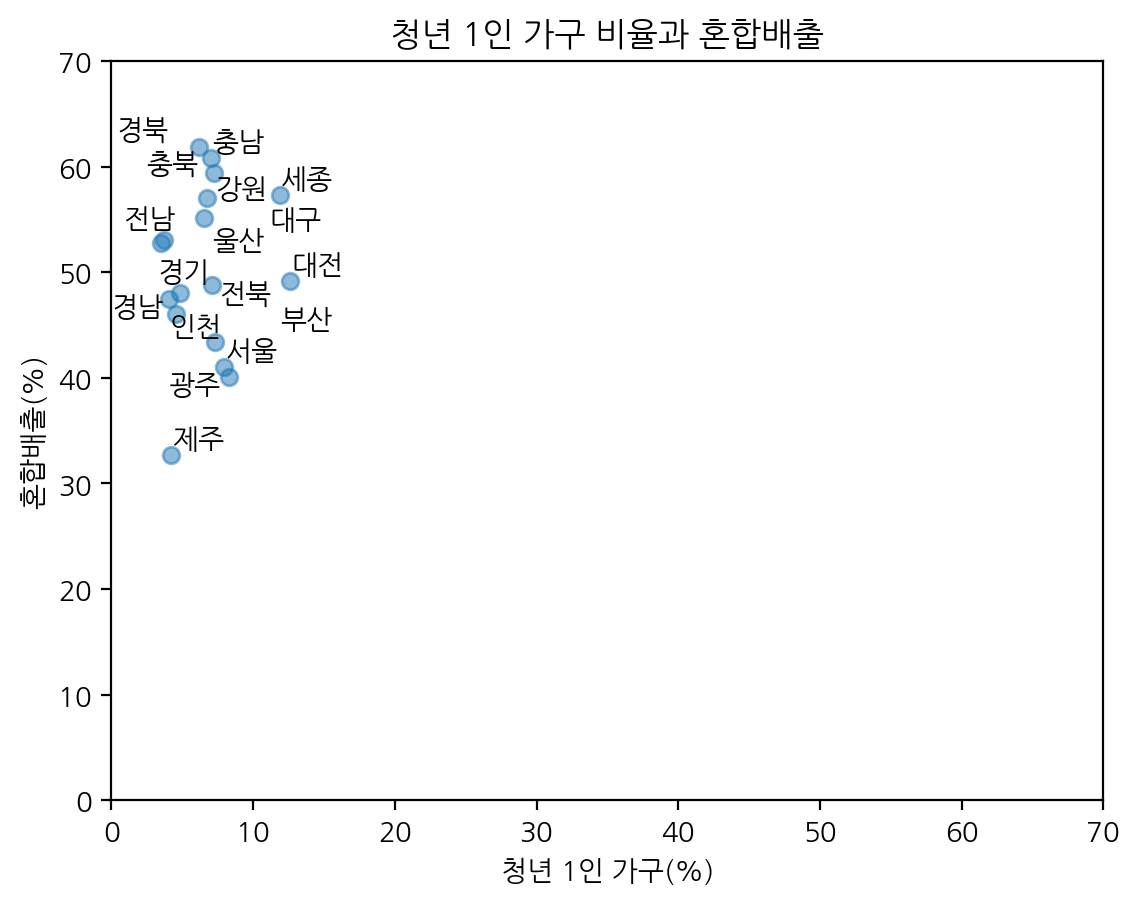

In [6]:
# 2030 1인 가구와의 상관관계
sql = open("04.select_young_single_and_trash.sql").read()
mycursor.execute(sql)
result = mycursor.fetchall()

young_single_rate_list = []

for v in result:
    young_single_rate_list.append(v[1])

plt.xlim(0, 70)
plt.ylim(0, 70)
plt.scatter(young_single_rate_list, mix_rate_list, alpha=0.5)
texts = show_label(region_list, young_single_rate_list, mix_rate_list, 0, 0, 'left')
adjust_text(texts)
plt.title('청년 1인 가구 비율과 혼합배출')
plt.xlabel('청년 1인 가구(%)')
plt.ylabel('혼합배출(%)')
plt.show();

In [16]:
np.cov(np.array(young_single_rate_list, dtype=float), 
       np.array(mix_rate_list, dtype=float))[0,1]

3.008822352229854

In [17]:
stats.pearsonr(np.array(young_single_rate_list, dtype=float), 
               np.array(mix_rate_list, dtype=float))
# 영향 전혀 없음

PearsonRResult(statistic=0.14460929777085263, pvalue=0.5797509458388047)

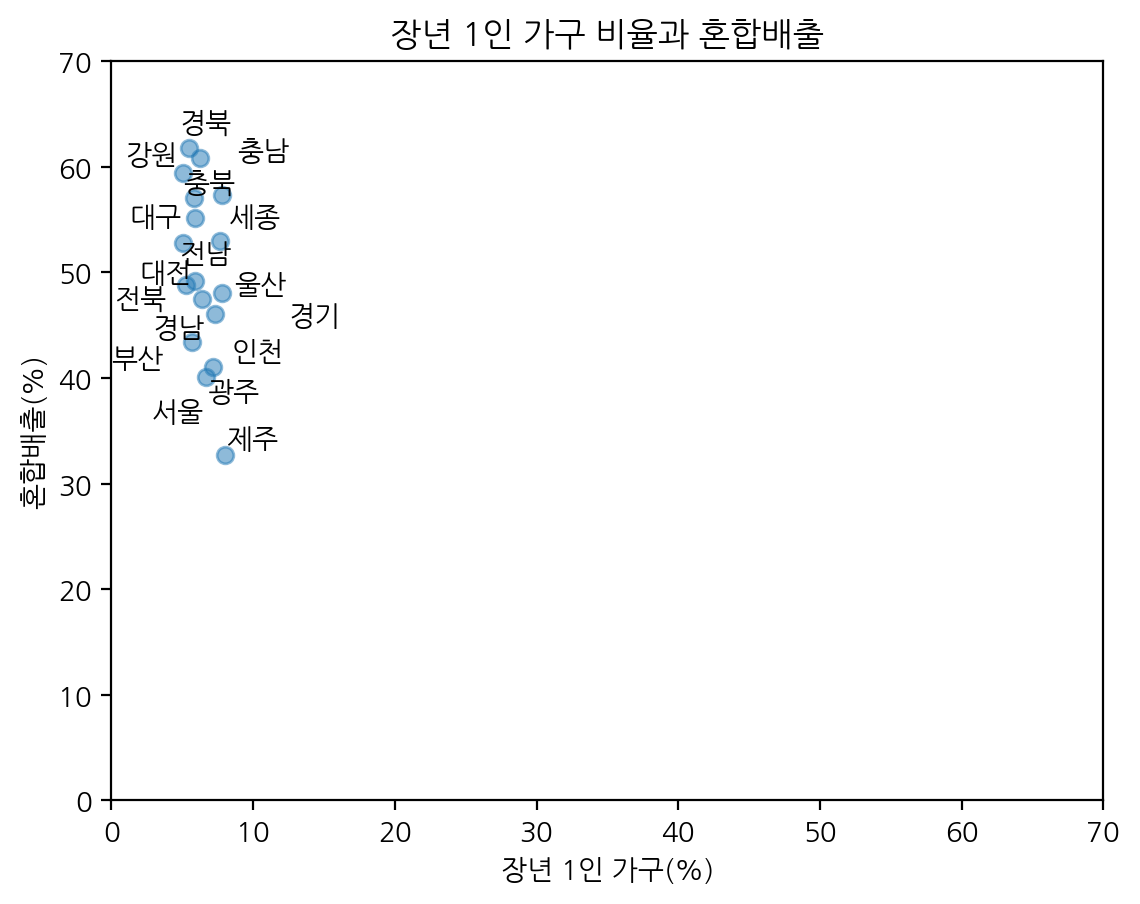

In [18]:
# 4050 1인 가구 비율은 영향이 있을까?
sql = open("05.select_older_single_and_trash.sql").read()
mycursor.execute(sql)
result = mycursor.fetchall()

region_list = []
older_single_rate_list = []

for v in result:
    region_list.append(v[0])
    older_single_rate_list.append(v[1])

plt.xlim(0, 70)
plt.ylim(0, 70)
plt.scatter(older_single_rate_list, mix_rate_list, alpha=0.5)
texts = show_label(region_list, older_single_rate_list, mix_rate_list, 0, 0, 'left')
adjust_text(texts)
plt.title('장년 1인 가구 비율과 혼합배출')
plt.xlabel('장년 1인 가구(%)')
plt.ylabel('혼합배출(%)')
plt.show();

In [19]:
np.cov(np.array(older_single_rate_list, dtype=float), 
       np.array(mix_rate_list, dtype=float))[0,1]

# 장년층 1인 가구 비율은 혼합배출 비율과 음의 상관관계를 가짐

-3.668480979344171

In [20]:
stats.pearsonr(np.array(older_single_rate_list, dtype=float), 
               np.array(mix_rate_list, dtype=float))

# 상관관계가 -0.44이므로 음의 상관관계가 있다고 볼 수 있다 (강한 수준은 아님)
# p value도 0.07 정도로 타 연령대에 비해 상관계수의 신뢰성이 있음

PearsonRResult(statistic=-0.44420419183920934, pvalue=0.0740476000033562)

- 4050 1인 가구는 분리배출을 잘하는 편
- 그러나 이외의 연령대에서 분명한 상관관계는 보이지 않음

#### Q2. 거주 건물유형과 혼합배출은 상관있을까?

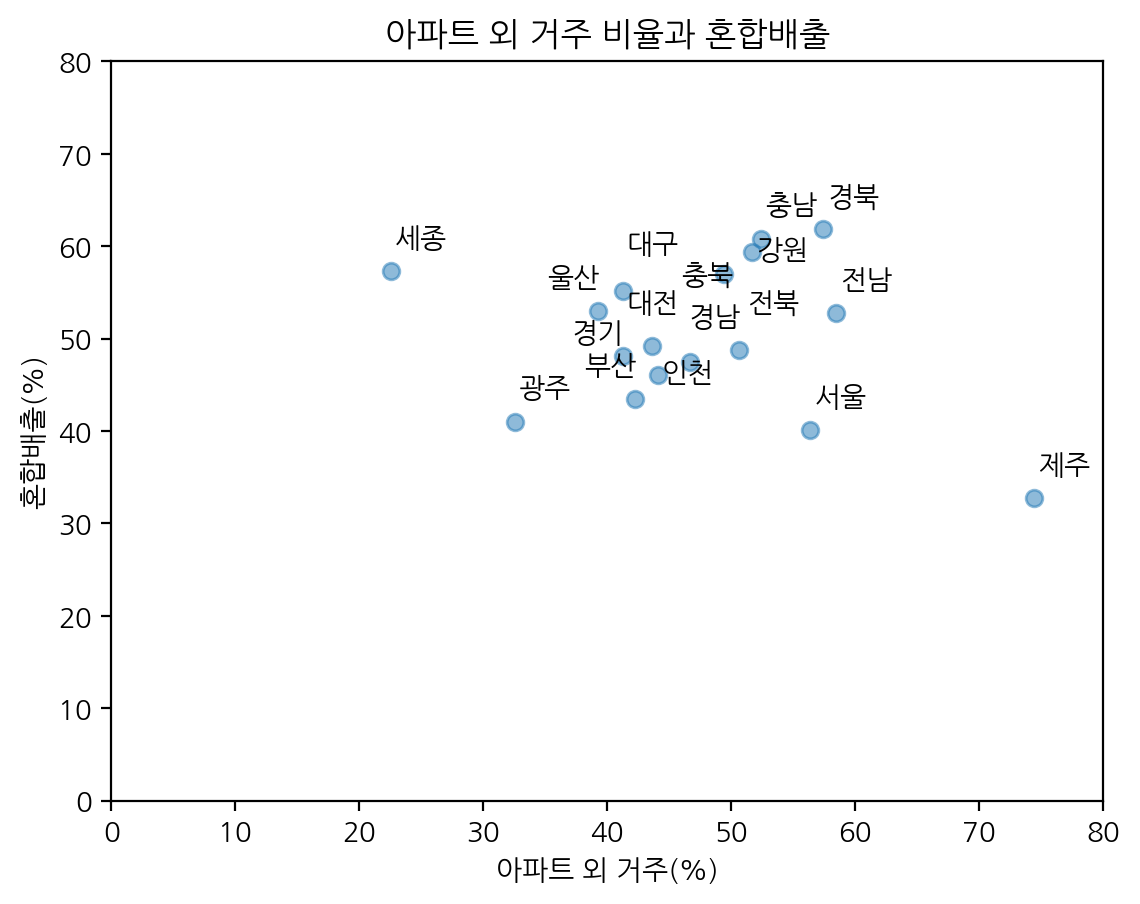

In [3]:
# 아파트 외 거주 비율
sql = open("06.select_non_apt_and_trash.sql", encoding="UTF-8").read()  # 윈도우에서 사용하는 코덱이 CP949라 에러발생하여 인코딩 옵션 추가
mycursor.execute(sql)
result = mycursor.fetchall()

region_list = []
non_apt_rate_list = []
mix_rate_list = []

for v in result:
    region_list.append(v[0])
    non_apt_rate_list.append(float(v[1]))
    mix_rate_list.append(float(v[2]))

plt.xlim(0, 80)
plt.ylim(0, 80)
plt.scatter(non_apt_rate_list, mix_rate_list, alpha=0.5)
texts = show_label(region_list, non_apt_rate_list, mix_rate_list, 1, 6, 'left')
adjust_text(texts)
plt.title('아파트 외 거주 비율과 혼합배출')
plt.xlabel('아파트 외 거주(%)')
plt.ylabel('혼합배출(%)')
plt.show();  # 약간 상관 있어 보인다

- 세종은 신도시라 아파트 거주 비율이 매우 높다
- 제주는 관공도시 특성상 아파트 거주 비율이 낮다
- 세종과 제주를 제외한다면?

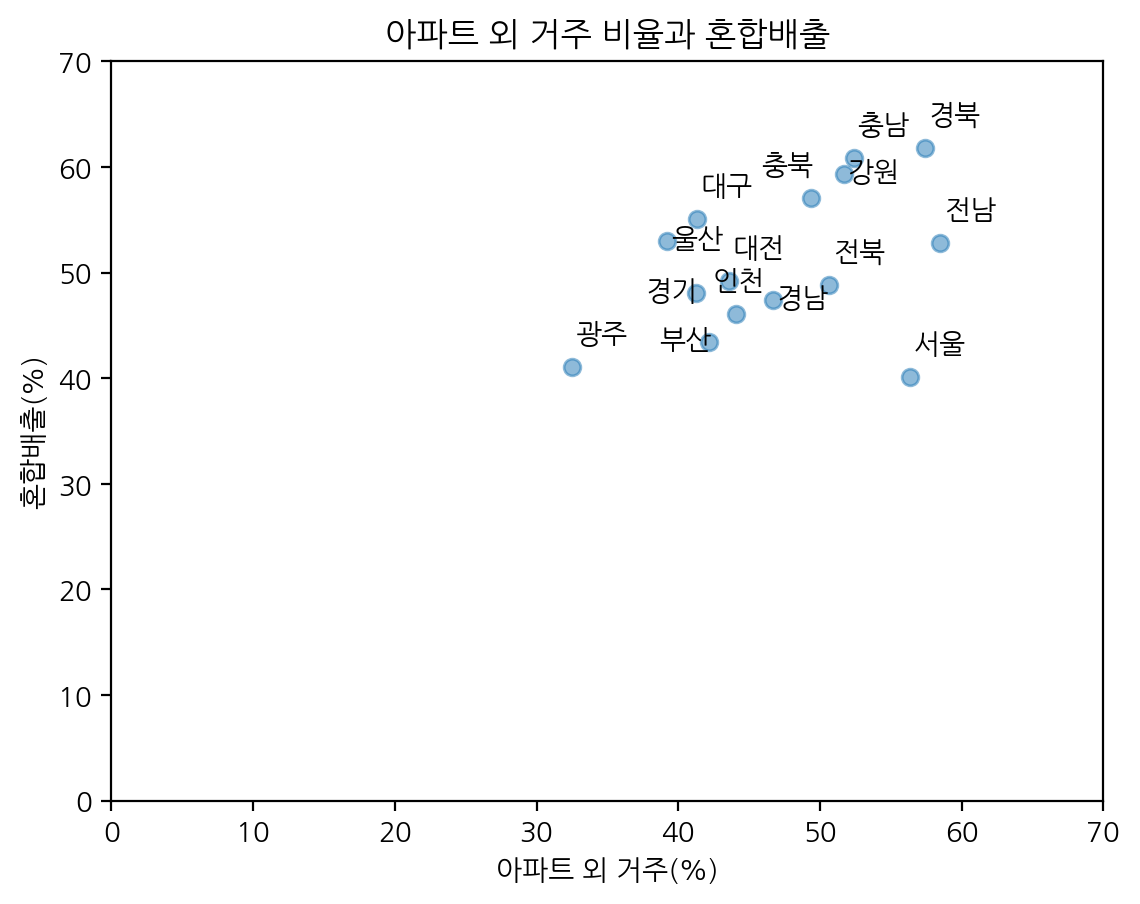

In [5]:
new_result = tuple(item for item in result if item[0] not in ('세종', '제주'))

region_list = []
non_apt_rate_list = []
new_mix_rate_list = []

for v in new_result:
    region_list.append(v[0])
    non_apt_rate_list.append(float(v[1]))
    new_mix_rate_list.append(v[2])

plt.xlim(0, 70)
plt.ylim(0, 70)
plt.scatter(non_apt_rate_list, new_mix_rate_list, alpha=0.5)
texts = show_label(region_list, non_apt_rate_list, new_mix_rate_list, 1, 6, 'left')
adjust_text(texts)
plt.title('아파트 외 거주 비율과 혼합배출')
plt.xlabel('아파트 외 거주(%)')
plt.ylabel('혼합배출(%)')
plt.show();

In [24]:
# 공분산 구하기
np.cov(np.array(non_apt_rate_list, dtype=float), 
       np.array(new_mix_rate_list, dtype=float))[0,1]

22.131061082585536

In [25]:
# 상관계수, p-value
stats.pearsonr(np.array(non_apt_rate_list, dtype=float), 
               np.array(new_mix_rate_list, dtype=float))

PearsonRResult(statistic=0.42839120512612694, pvalue=0.11112688404697656)

- 양의 상관관계가 있음: 0.4
- p-value가 0.11이므로 상관계수의 신뢰성은 89% 정도
- 어느 정도 상관이 있는 것으로 보인다.

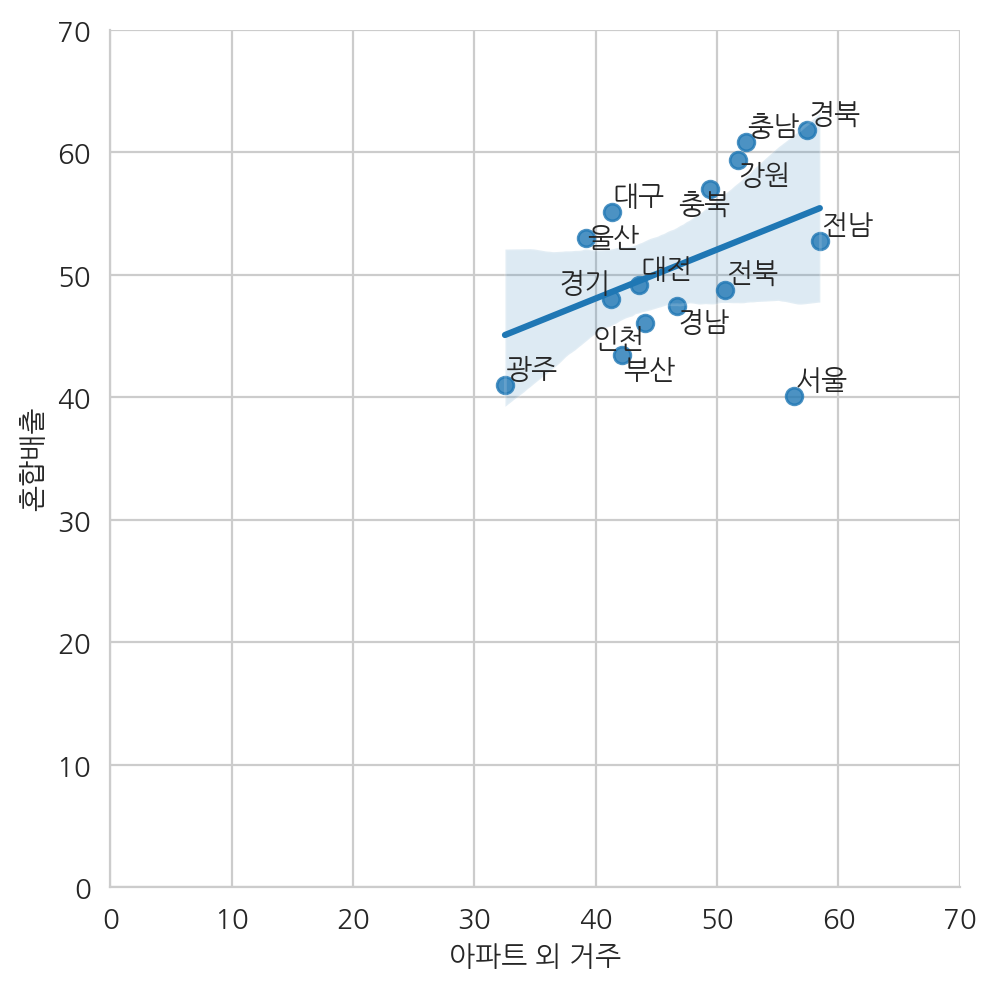

In [10]:
# sns.set_style('whitegrid')

sns_df = pd.DataFrame(data=zip(non_apt_rate_list, new_mix_rate_list, region_list),
                      columns=['아파트 외 거주', '혼합배출', '지역'])

sns.lmplot(data=sns_df, x='아파트 외 거주', y='혼합배출')

plt.xlim(0, 70)
plt.ylim(0, 70)

texts = show_label(region_list, non_apt_rate_list, new_mix_rate_list, 0, 0, 'center')
adjust_text(texts)

plt.show();

#### Q3. 거주 면적은 상관있을까?

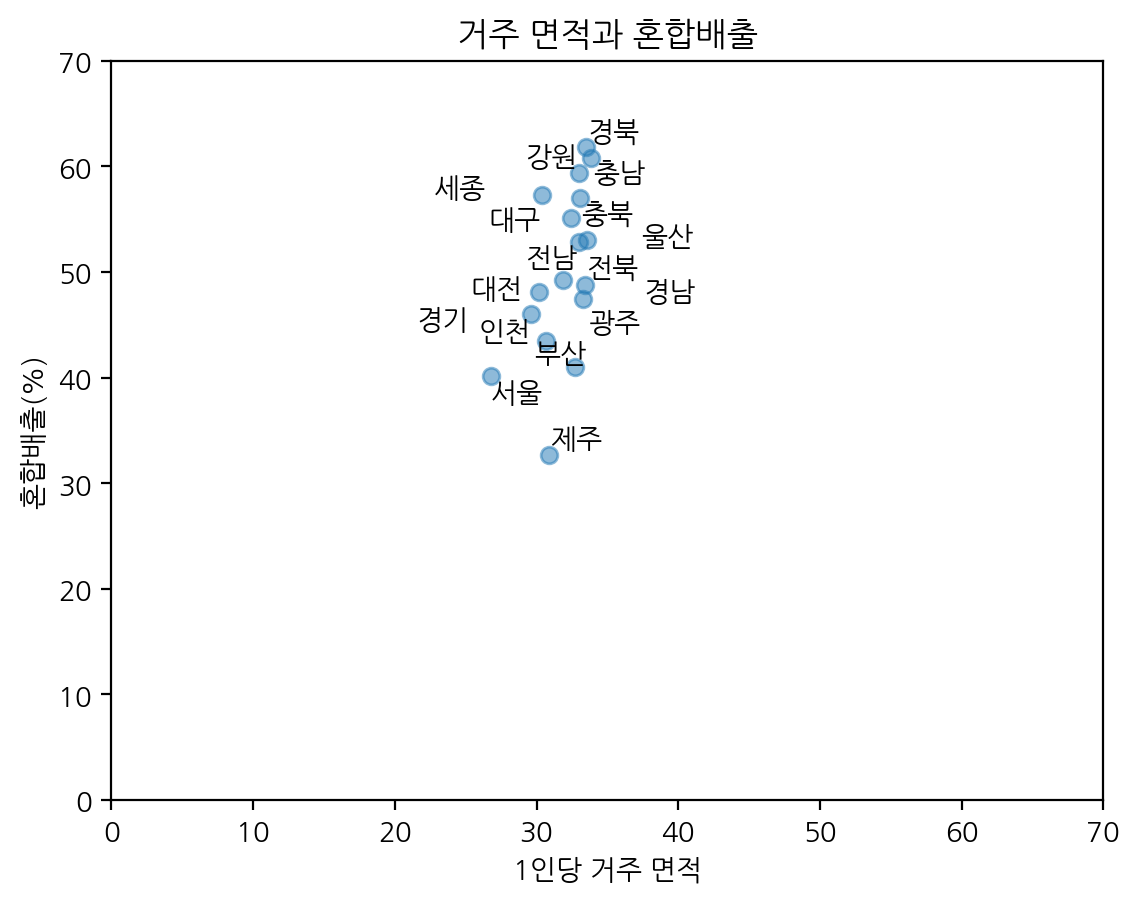

In [20]:
sql = open('14.select_space_and_mix.sql').read()
mycursor.execute(sql)
result = mycursor.fetchall()

region_list = []
space_list = []
mix_rate_list = []

for v in result:
    region_list.append(v[0])
    space_list.append(float(v[1]))
    mix_rate_list.append(float(v[2]))

plt.xlim(0, 70)
plt.ylim(0, 70)
plt.scatter(space_list, mix_rate_list, alpha=0.5)
texts = show_label(region_list, space_list, mix_rate_list, 0, 0, 'left')
adjust_text(texts)
plt.title('거주 면적과 혼합배출')
plt.xlabel('1인당 거주 면적')
plt.ylabel('혼합배출(%)')
plt.show();

In [12]:
# 공분산 구하기
np.cov(np.array(space_list, dtype=float), 
       np.array(mix_rate_list, dtype=float))[0,1]

8.37719239651284

In [13]:
# 상관계수, p-value
stats.pearsonr(np.array(space_list, dtype=float), 
               np.array(mix_rate_list, dtype=float))

PearsonRResult(statistic=0.5526827128159468, pvalue=0.021399793667154395)

In [15]:
plt.style.use('default')

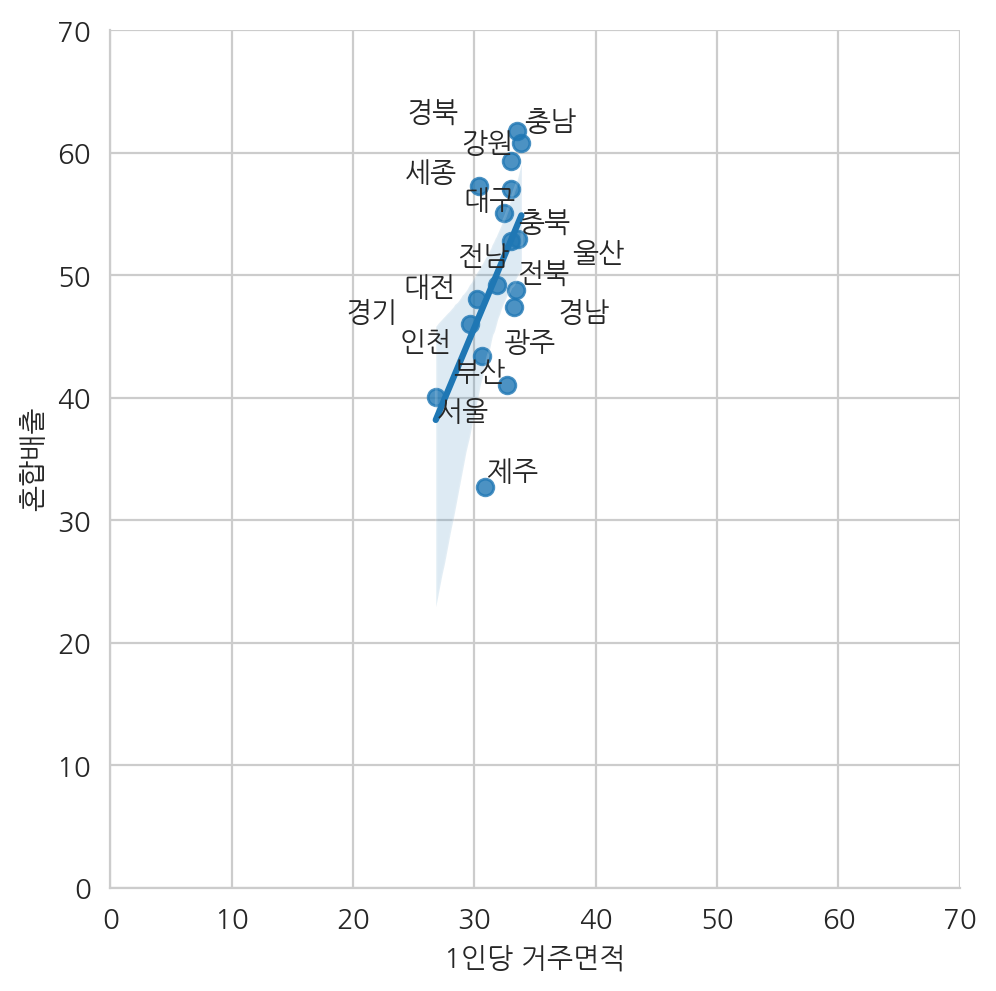

In [14]:
sns_df = pd.DataFrame(data=zip(space_list, mix_rate_list, region_list),
                      columns=['1인당 거주면적', '혼합배출', '지역'])

sns.lmplot(data=sns_df, x='1인당 거주면적', y='혼합배출')

plt.xlim(0, 70)
plt.ylim(0, 70)

texts = show_label(region_list, space_list, mix_rate_list, 0, 0, 'center')
adjust_text(texts)

plt.show();  # 양의 상관관계가 있는데, 사실 일반적으로 도시의 거주면적이 좁다.
# 도시일수록 혼합배출 비율이 낮은 것으로 보인다.